# Results

In [1]:
import sys
import os

# Get the parent directory of the current directory (subdir2)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

from pmf import PMFModel

from report.simulation.data import Data

In [3]:
# Set the Computer Modern font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern"
plt.rcParams["text.usetex"] = True

In [4]:
models_folder_path = "models"
pictures_folder_path = "pictures"

## Latent Representations

In [5]:
# Load the model
model = PMFModel.load(os.path.join(models_folder_path, "model.pkl"))

# Load the data
data = Data.load("data.pkl", verbose=True)

print(data)

Data loaded from data.pkl!


In [6]:
# Extract the estimates for x and y from the model
estimate_x = model.estimates.x
estimate_y = model.estimates.y

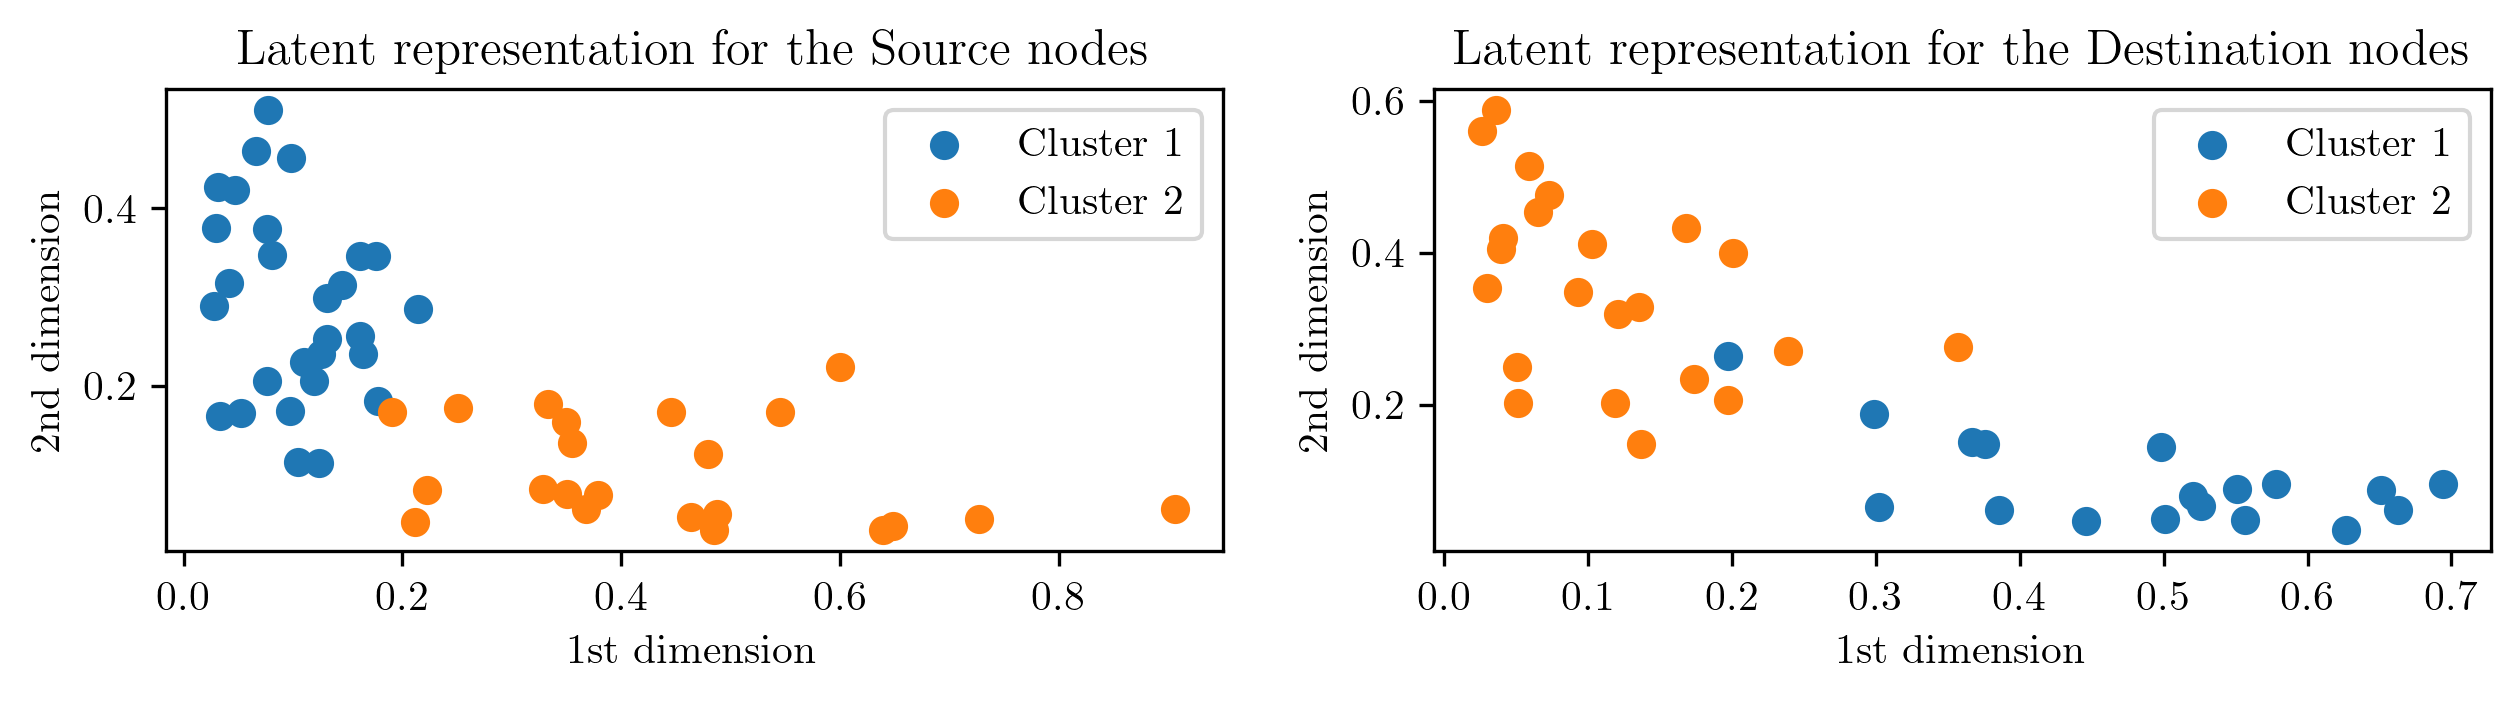

In [7]:
# Use a color-blind friendly palette
colors = plt.get_cmap("tab10").colors


def plot_latent_representation(ax, clusters, k, estimates, title):
    for i in range(k):
        indices = clusters == i
        ax.scatter(
            estimates[indices, 0],
            estimates[indices, 1],
            color=colors[i],
            label=f"Cluster {i + 1}",
        )
    ax.legend()
    ax.set_xlabel("1st dimension")
    ax.set_ylabel("2nd dimension")
    ax.set_title(title)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), dpi=300)

# Plot the latent representation of the source nodes
plot_latent_representation(
    ax1,
    data.Fx,
    data.k1,
    estimate_x,
    "Latent representation for the Source nodes",
)

# Plot the latent representation of the destination nodes
plot_latent_representation(
    ax2,
    data.Fy,
    data.k2,
    estimate_y,
    "Latent representation for the Destination nodes",
)

# Save the plot to a file
plt.savefig(
    os.path.join(pictures_folder_path, "latent_representation.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()

In [8]:
# Get the true latent features by performing SVD on the probability matrix
B = data.probability_matrix
U, D, V = svd(B)
x_true = np.abs(U @ np.diag(np.sqrt(D)))
y_true = np.abs(V.T @ np.diag(np.sqrt(D)))

# Get the true correction factors
true_rhox = data.rho_x
true_rhoy = data.rho_y

# Get the estimates for the correction factors
estimate_rhox = model.estimates.rhox
estimate_rhoy = model.estimates.rhoy


def adjust_estimates(estimates, true_values, clusters, k):
    adjusted_estimates = np.zeros_like(estimates)

    for i in range(k):
        indices = clusters == i
        scaling_factor = np.sum(estimates[:, indices]) / np.sum(true_values[:, indices])
        adjusted_estimates[:, indices] = estimates[:, indices] / scaling_factor

    return adjusted_estimates


# Adjust the estimates for the latent features
adjusted_estimate_rhox = adjust_estimates(estimate_rhox, true_rhox, data.Fx, data.k1)
adjusted_estimate_rhoy = adjust_estimates(estimate_rhoy, true_rhoy, data.Fy, data.k2)

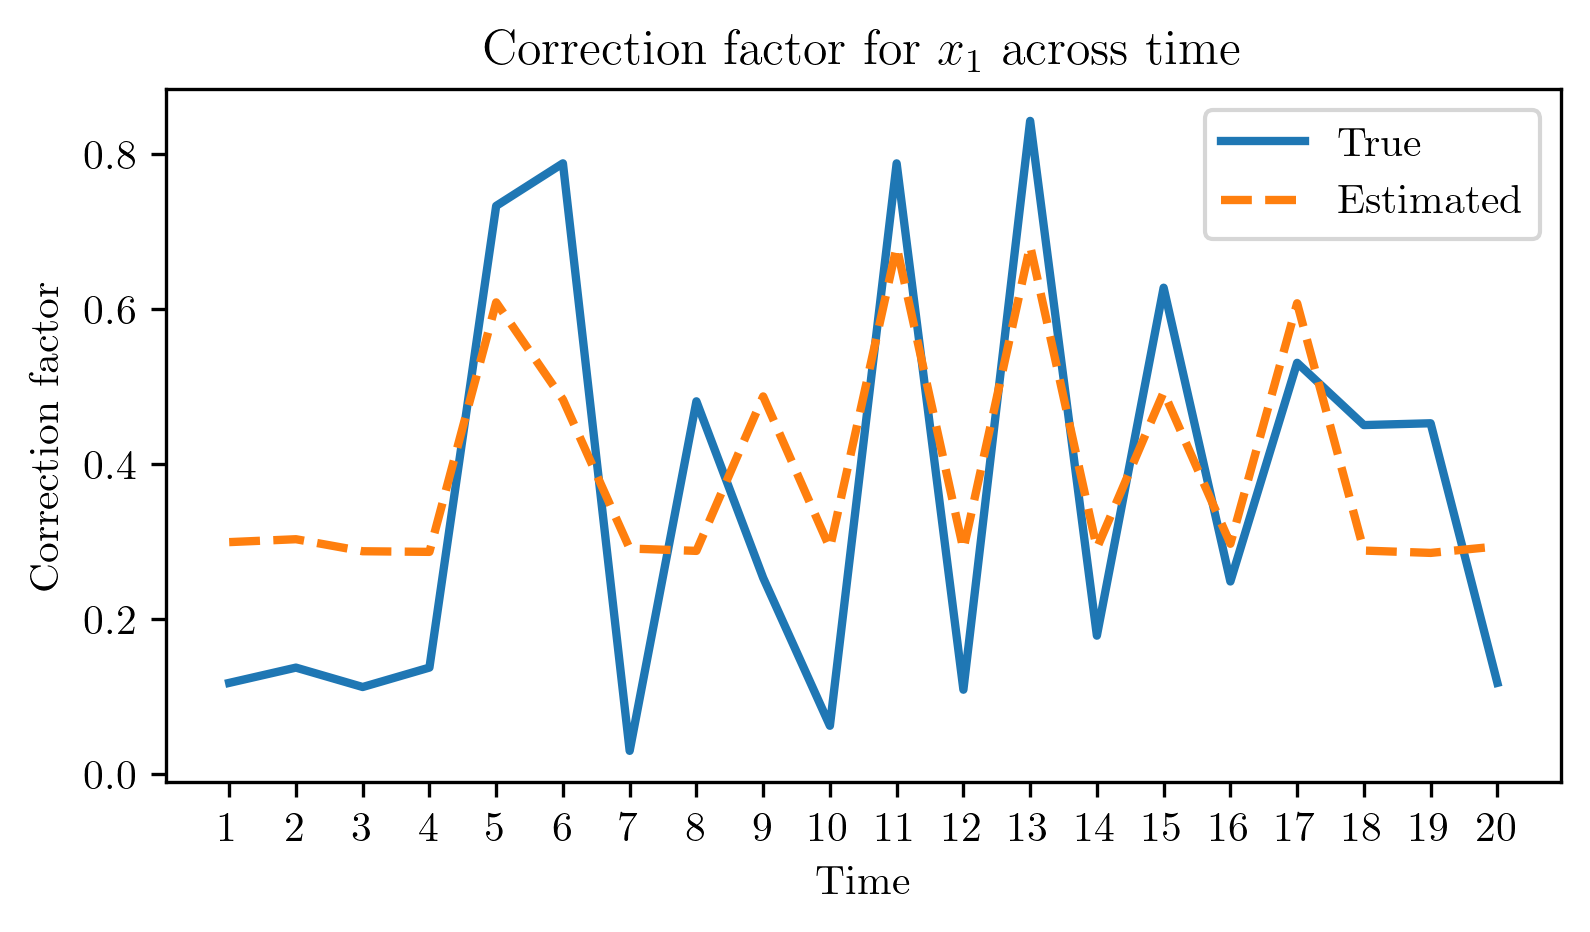

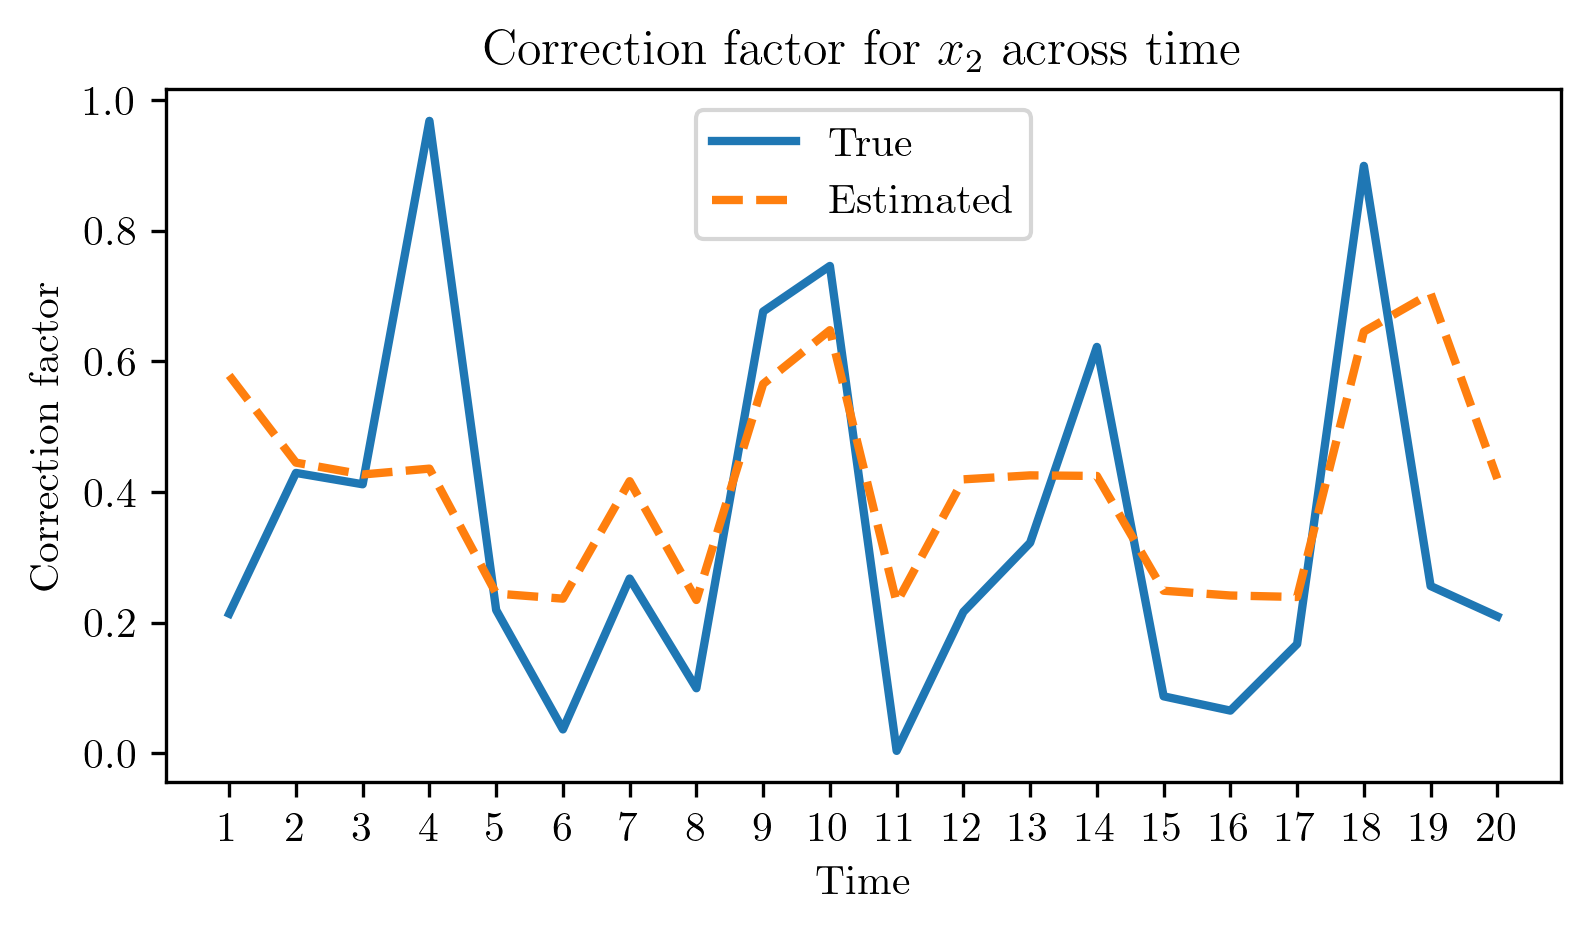

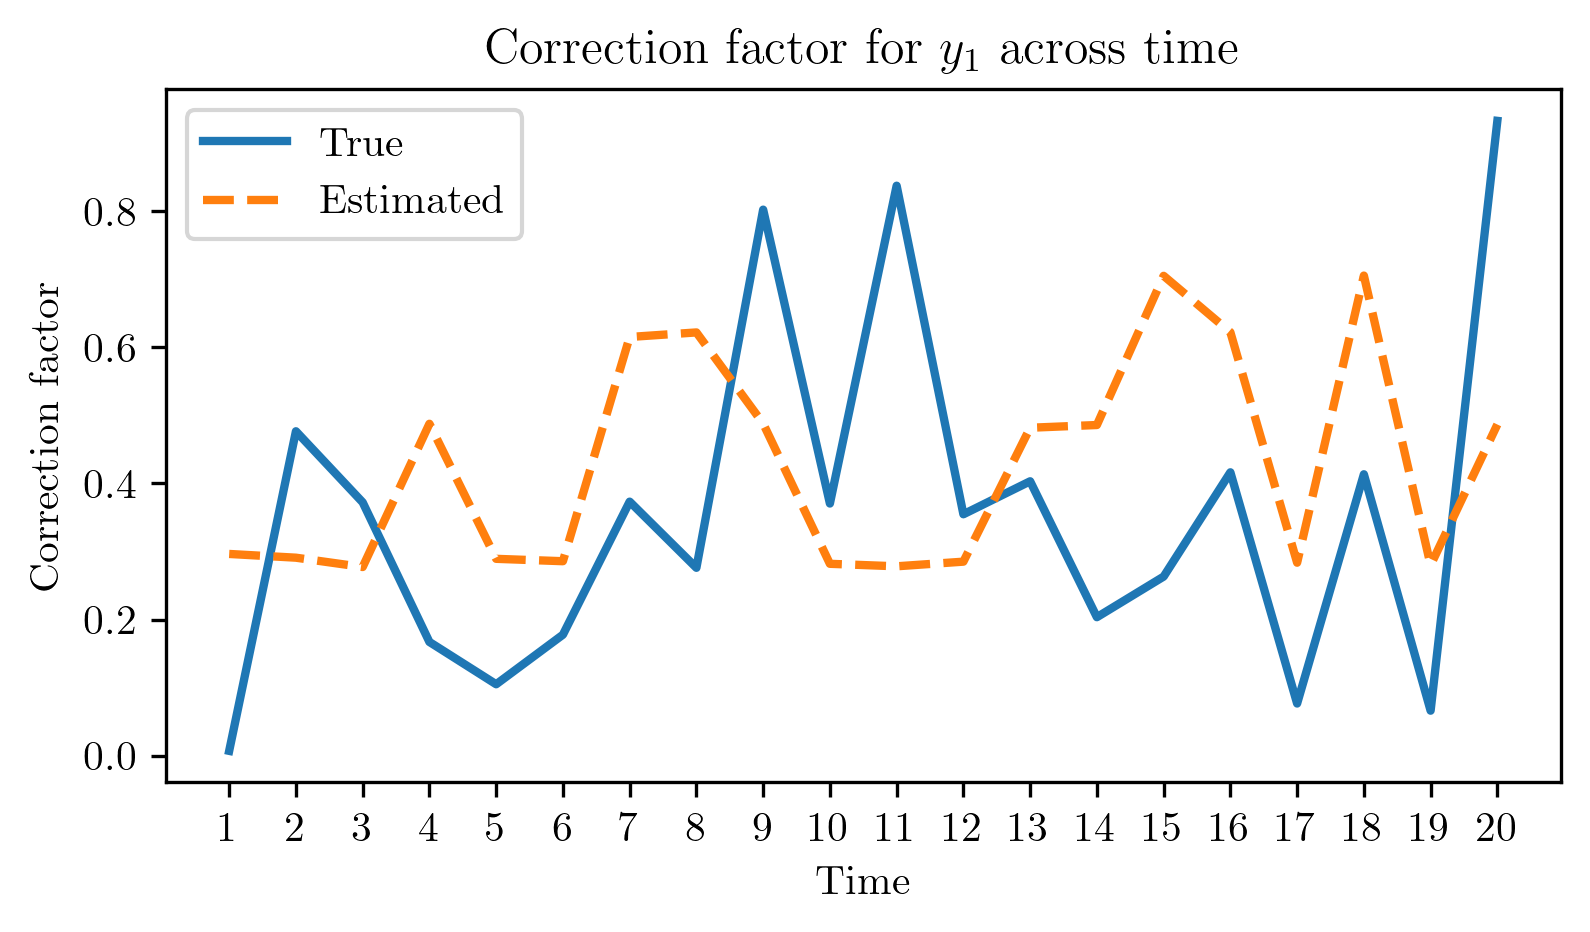

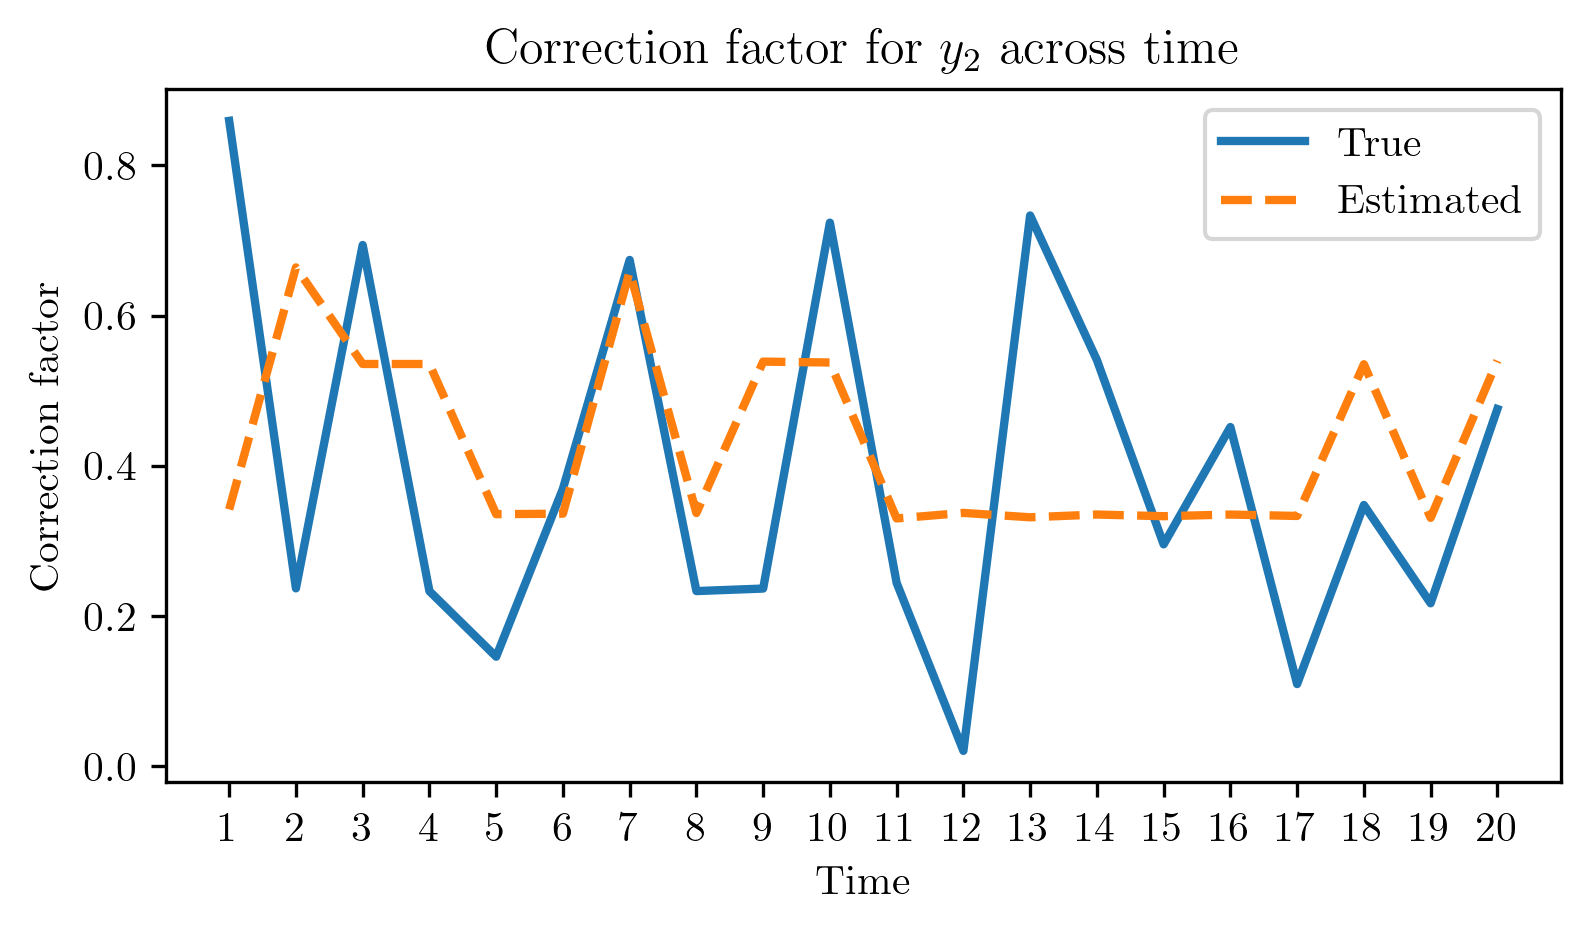

In [9]:
# Use a color-blind friendly palette
colors = plt.get_cmap("tab10").colors


def plot_correction_factors(true, estimated, title: str, file_name: str):
    plt.figure(figsize=(6, 3), dpi=300)

    range = np.arange(len(true)) + 1

    plt.plot(range, true, label="True", color=colors[0], linewidth=2, linestyle="-")
    plt.plot(
        range,
        estimated,
        label="Estimated",
        color=colors[1],
        linewidth=2,
        linestyle="--",
    )

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Correction factor")
    plt.xticks(range)
    plt.legend()

    plt.savefig(
        os.path.join(pictures_folder_path, file_name),
        format="pdf",
        bbox_inches="tight",
    )

    plt.show()


plot_correction_factors(
    true_rhox[:, 0],
    adjusted_estimate_rhox[:, 0],
    r"Correction factor for $x_1$ across time",
    "correction-factors_x1.pdf",
)
plot_correction_factors(
    true_rhox[:, 1],
    adjusted_estimate_rhox[:, 1],
    r"Correction factor for $x_2$ across time",
    "correction-factors_x2.pdf",
)
plot_correction_factors(
    true_rhoy[:, 0],
    adjusted_estimate_rhoy[:, 0],
    r"Correction factor for $y_1$ across time",
    "correction-factors_y1.pdf",
)
plot_correction_factors(
    true_rhoy[:, 1],
    adjusted_estimate_rhoy[:, 1],
    r"Correction factor for $y_2$ across time",
    "correction-factors_y2.pdf",
)

## Latent features initializations

In [10]:
# Load the models
model = PMFModel.load(os.path.join(models_folder_path, "model.pkl"))
constant_model = PMFModel.load(os.path.join(models_folder_path, "model_constant.pkl"))
random_uniform_model = PMFModel.load(
    os.path.join(models_folder_path, "model_random_uniform.pkl")
)
random_beta_model = PMFModel.load(
    os.path.join(models_folder_path, "model_random_beta.pkl")
)
random_gamma_model = PMFModel.load(
    os.path.join(models_folder_path, "model_random_gamma.pkl")
)

In [11]:
def plot_eval(
    model,
    constant_model,
    random_uniform_model,
    random_beta_model,
    random_gamma_model,
    type: str,
    title: str,
    xlabel: str,
    file: str,
    file_format: str,
    max_iter: int = None,
):
    def select_eval_type(model):
        match type:
            case "elbo":
                return model.cavi_results.elbo_values
            case "log_likelihood":
                return model.cavi_results.log_likelihood_values
            case _:
                raise ValueError(f"Unknown type: {type}")

    def select_eval_indices(model):
        model_max_iter = len(model.cavi_results.eval_indices)
        if max_iter is not None:
            model_max_iter = min(max_iter, model_max_iter)
        return (
            model.cavi_results.eval_indices[:model_max_iter],
            select_eval_type(model)[:model_max_iter],
        )

    model_eval_indices, model_eval_values = select_eval_indices(model)
    constant_model_eval_indices, constant_model_eval_values = select_eval_indices(
        constant_model
    )
    random_uniform_model_eval_indices, random_uniform_model_eval_values = (
        select_eval_indices(random_uniform_model)
    )
    random_beta_model_eval_indices, random_beta_model_eval_values = select_eval_indices(
        random_beta_model
    )
    random_gamma_model_eval_indices, random_gamma_model_eval_values = select_eval_indices(
        random_gamma_model
    )

    # Use a color-blind friendly palette
    colors = colors = plt.get_cmap("tab10").colors

    plt.figure(figsize=(6, 4), dpi=300)

    plt.plot(
        model_eval_indices,
        model_eval_values,
        label="SVD",
        color=colors[0],
        linestyle="-",
        linewidth=2,
    )
    plt.plot(
        constant_model_eval_indices,
        constant_model_eval_values,
        label="Constant",
        color=colors[1],
        linestyle="--",
        linewidth=2,
    )
    plt.plot(
        random_uniform_model_eval_indices,
        random_uniform_model_eval_values,
        label="Random Uniform",
        color=colors[2],
        linestyle=":",
        linewidth=2,
    )
    plt.plot(
        random_beta_model_eval_indices,
        random_beta_model_eval_values,
        label="Random Beta",
        color=colors[3],
        linestyle=":",
        linewidth=2,
    )
    plt.plot(
        random_gamma_model_eval_indices,
        random_gamma_model_eval_values,
        label="Random Gamma",
        color=colors[6],
        linestyle="-.",
        linewidth=2,
    )

    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(xlabel)
    plt.legend()

    # Save the plot to a file
    plt.savefig(file, format=file_format, bbox_inches="tight")

    plt.show()

In [12]:
def min_elbo_diff(model):
  return np.min(np.diff(model.cavi_results.elbo_values))

print(
    "ELBO Minimum Difference for SVD: ",
    min_elbo_diff(model),
)
print(
    "ELBO Minimum Difference for Constant: ",
    min_elbo_diff(constant_model),
)
print(
    "ELBO Minimum Difference for Random Uniform: ",
    min_elbo_diff(random_uniform_model),
)
print(
    "ELBO Minimum Difference for Random Beta: ",
    min_elbo_diff(random_beta_model),
)
print(
    "ELBO Minimum Difference for Random Gamma: ",
    min_elbo_diff(random_gamma_model),
)

ELBO Minimum Difference for SVD:  0.0037230261896183947
ELBO Minimum Difference for Constant:  0.004281421233827132
ELBO Minimum Difference for Random Uniform:  0.004281421233827132
ELBO Minimum Difference for Random Beta:  0.004110702161597146
ELBO Minimum Difference for Random Gamma:  0.0038509753849211847


In [13]:
# Print the number of iterations up until convergence
print(
    "Number of iterations for SVD: ",
    model.cavi_results.eval_indices[-1],
)
print(
    "Number of iterations for Constant: ",
    constant_model.cavi_results.eval_indices[-1],
)
print(
    "Number of iterations for Random Uniform: ",
    random_uniform_model.cavi_results.eval_indices[-1],
)
print(
    "Number of iterations for Random Beta: ",
    random_beta_model.cavi_results.eval_indices[-1],
)
print(
    "Number of iterations for Random Gamma: ",
    random_gamma_model.cavi_results.eval_indices[-1],
)

Number of iterations for SVD:  82
Number of iterations for Constant:  94
Number of iterations for Random Uniform:  94
Number of iterations for Random Beta:  74
Number of iterations for Random Gamma:  96


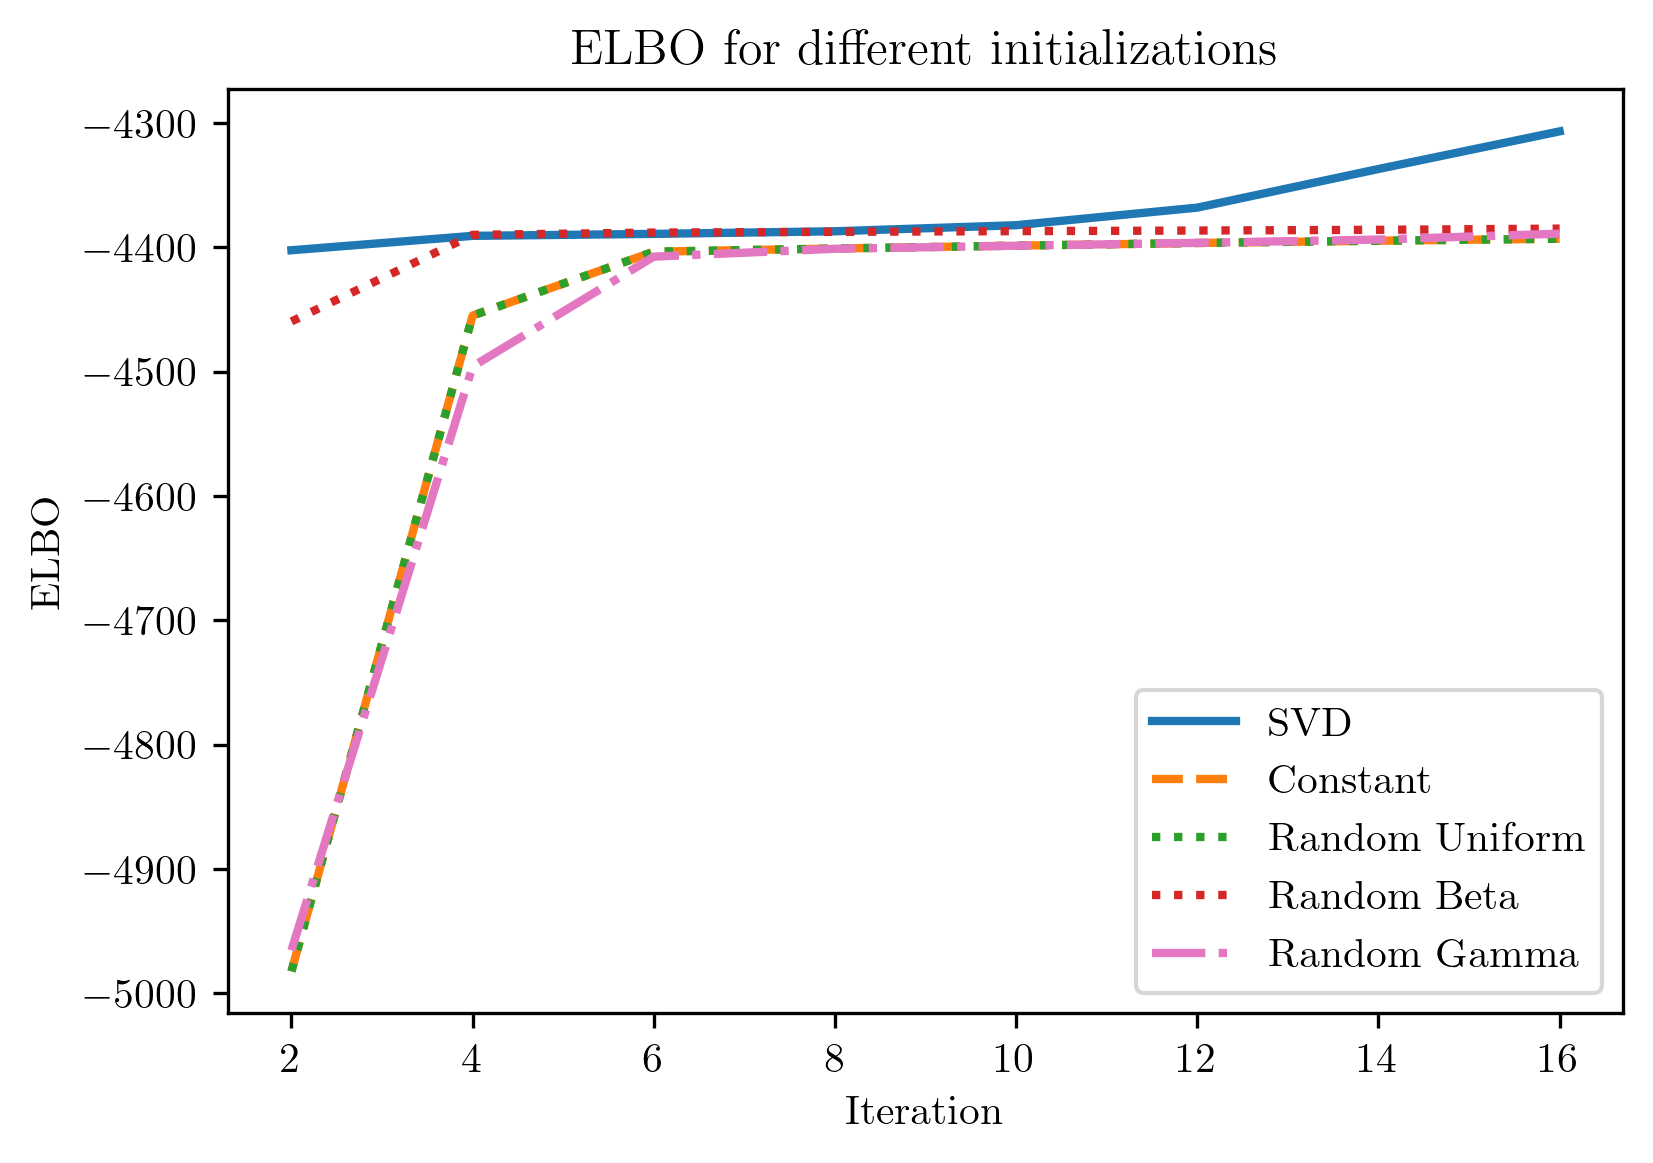

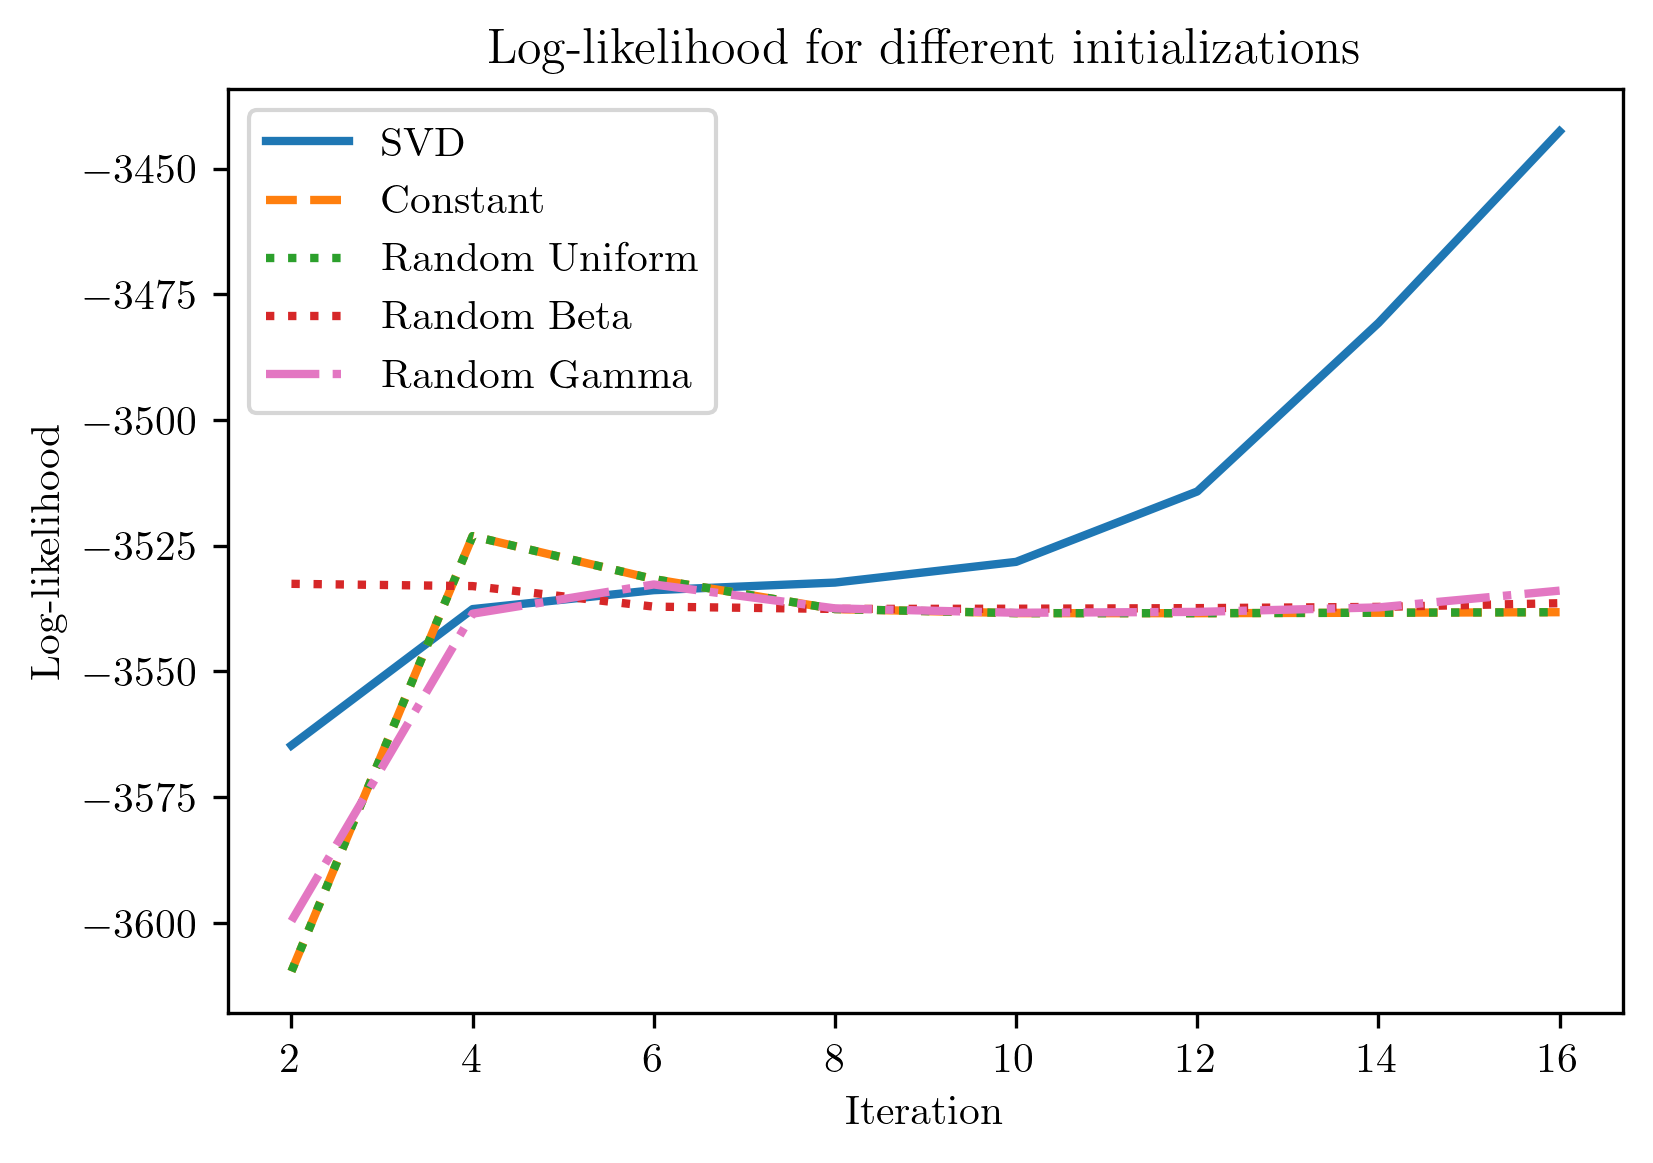

In [14]:
max_iter = 8

# Plot the ELBO values for the models
plot_eval(
    model=model,
    constant_model=constant_model,
    random_uniform_model=random_uniform_model,
    random_beta_model=random_beta_model,
    random_gamma_model=random_gamma_model,
    type="elbo",
    title="ELBO for different initializations",
    xlabel="ELBO",
    file=os.path.join(pictures_folder_path, "elbo_1.pdf"),
    file_format="pdf",
    max_iter=max_iter,
)

# Plot the log-likelihood values for the models
plot_eval(
    model=model,
    constant_model=constant_model,
    random_uniform_model=random_uniform_model,
    random_beta_model=random_beta_model,
    random_gamma_model=random_gamma_model,
    type="log_likelihood",
    title="Log-likelihood for different initializations",
    xlabel="Log-likelihood",
    file=os.path.join(pictures_folder_path, "log_likelihood_1.pdf"),
    file_format="pdf",
    max_iter=max_iter,
)

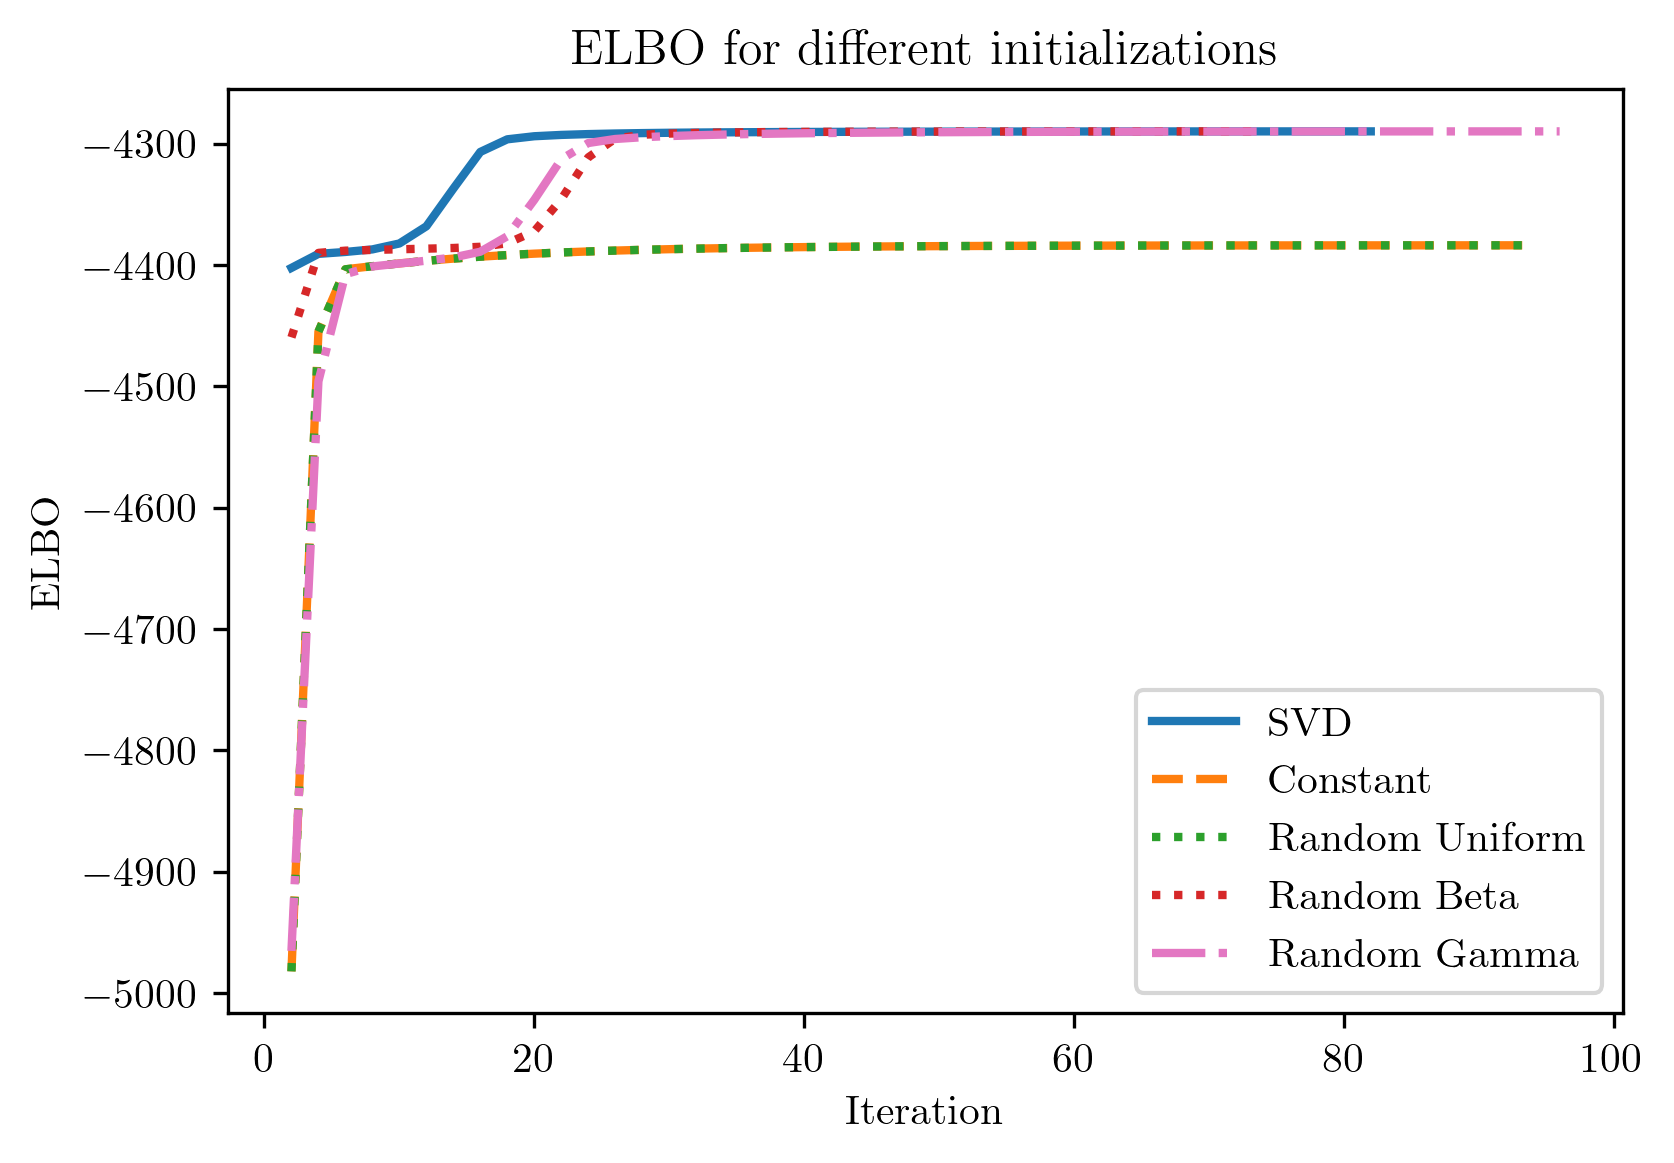

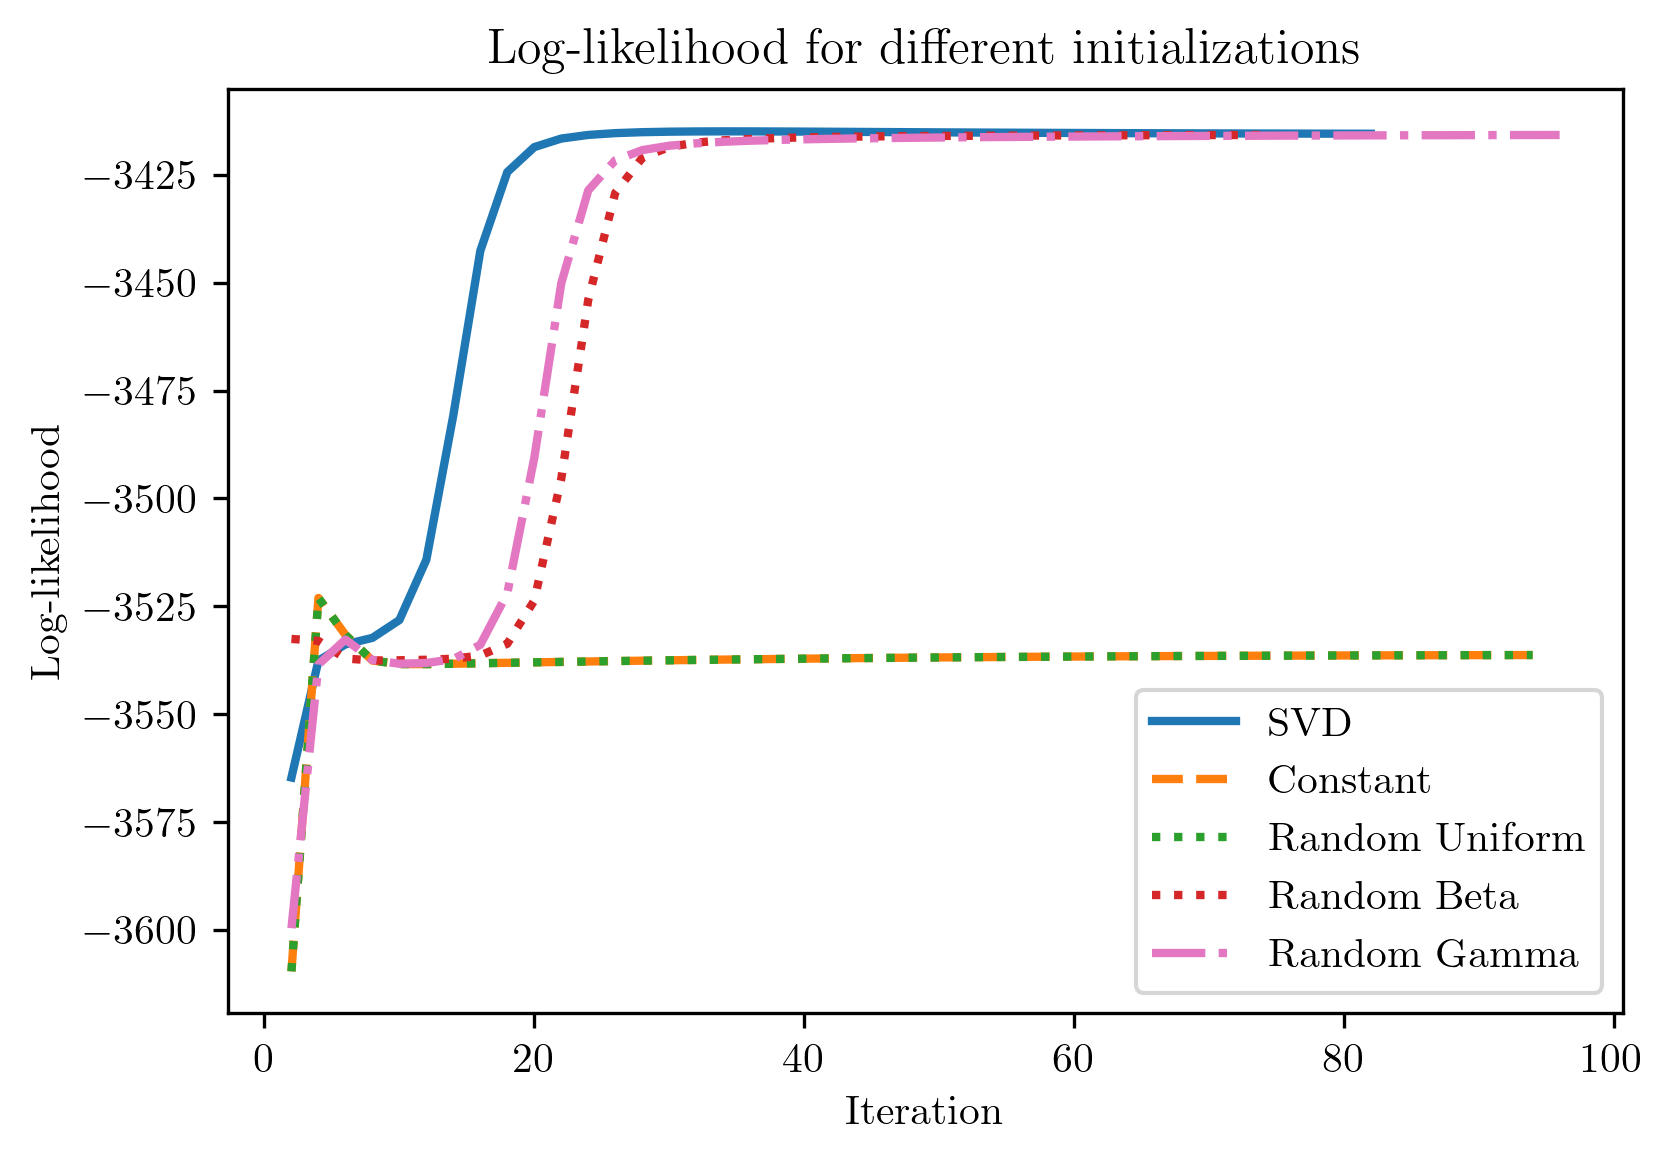

In [15]:
max_iter = None

# Plot the ELBO values for the models
plot_eval(
    model=model,
    constant_model=constant_model,
    random_uniform_model=random_uniform_model,
    random_beta_model=random_beta_model,
    random_gamma_model=random_gamma_model,
    type="elbo",
    title="ELBO for different initializations",
    xlabel="ELBO",
    file=os.path.join(pictures_folder_path, "elbo_2.pdf"),
    file_format="pdf",
    max_iter=max_iter,
)

# Plot the log-likelihood values for the models
plot_eval(
    model=model,
    constant_model=constant_model,
    random_uniform_model=random_uniform_model,
    random_beta_model=random_beta_model,
    random_gamma_model=random_gamma_model,
    type="log_likelihood",
    title="Log-likelihood for different initializations",
    xlabel="Log-likelihood",
    file=os.path.join(pictures_folder_path, "log-likelihood_2.pdf"),
    file_format="pdf",
    max_iter=max_iter,
)